### TUTORIAL

In [73]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import Bunch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
import nltk
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import numpy as np 

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [74]:
    categories = ["not_sexist", "sexist"]
    #               2161           989

In [75]:
data = pd.read_csv("my_csv.csv",sep = ',')
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class']

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

### Tokenizing text with scikit-learn

In [76]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2204, 11289)

In [77]:
count_vect.vocabulary_.get(u'femme')

4021

### From occurrences to frequencies

In [78]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2204, 11289)

### Training a classifier

In [79]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [80]:
docs_new = ["Les hommes c'est tous les mêmes", 'Il est étudiant.'] #marche pas du tout
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))

"Les hommes c'est tous les mêmes" => not_sexist
'Il est étudiant.' => not_sexist


### Building a pipeline

In [81]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', MultinomialNB()),
... ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation of the performance on the test set

In [82]:
docs_test = X_test
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.6857142857142857

### SVM

In [83]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)),
... ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.7470899470899471

In [84]:
print(metrics.classification_report(y_test, predicted,
...     target_names=categories))

              precision    recall  f1-score   support

  not_sexist       0.75      0.92      0.83       634
      sexist       0.71      0.39      0.50       311

    accuracy                           0.75       945
   macro avg       0.73      0.66      0.67       945
weighted avg       0.74      0.75      0.72       945



In [85]:
metrics.confusion_matrix(y_test, predicted)

array([[586,  48],
       [191, 120]])

### Parameter tuning using grid search

In [86]:
parameters = {
...     'vect__ngram_range': [(1, 1), (1, 2)],
...     'tfidf__use_idf': (True, False),
...     'clf__alpha': (1e-2, 1e-3),
... }

In [87]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [88]:
gs_clf = gs_clf.fit(X_train[:100], y_train[:100])
#ameliorer vecteur et algo et representation
#-> plus de poids sur les mots sexistes

In [89]:
example_1 = 'La femme'
example_2 = "L'homme"
example_3 = "La femme doit être dans la cuisine"

print(example_1 + "  => " + str(categories[gs_clf.predict([example_1])[0]]))
print(example_2 + "  => " + str(categories[gs_clf.predict([example_2])[0]]))
print(example_3 + "  => " + str(categories[gs_clf.predict([example_3])[0]]))

La femme  => not_sexist
L'homme  => not_sexist
La femme doit être dans la cuisine  => not_sexist


In [90]:
gs_clf.best_score_

0.72

In [91]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.01
tfidf__use_idf: False
vect__ngram_range: (1, 2)


### Oversampling

In [92]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 1526, 1: 1526})


In [93]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(3052, 11289)

In [94]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3052, 11289)

In [95]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_ros_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)

"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7413249211356467


array([[405, 229],
       [ 99, 535]])

### Undersampling

In [96]:
# instantiating the random over sampler 
ros = RandomUnderSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 678, 1: 678})


In [97]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1356, 8098)

In [98]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1356, 8098)

In [99]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7282958199356914


array([[176, 135],
       [ 34, 277]])

### Oversampling and Undersampling

In [100]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)

In [101]:
X_over, y_over = over.fit_resample(np.array(X_train).reshape(-1,1), y_train)
print(f"Oversampled: {Counter(y_over)}")

Oversampled: Counter({0: 1526, 1: 763})


In [102]:
# now to comine under sampling 
X_ros, y_ros = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_ros)}")

Combined Random Sampling: Counter({0: 953, 1: 763})


In [103]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1716, 9158)

In [104]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1716, 9158)

In [105]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."]
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7202572347266881


array([[240,  71],
       [103, 208]])

### Word Embedding using Doc2Vec

###### 1st Step : Getting cleaned data

In [106]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

###### 2nd step : Keeping a tokenized version of the sentences and the corresponding categories

In [107]:
X_tokenized = []
y_tokenized = []

for sentence in X_train:
    X_tokenized.append(word_tokenize(sentence))    
    
for cat in y_train:
    y_tokenized.append(cat)

###### 3rd step : Defining a cosine function to compute the similaity between two vectors

In [108]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

###### 4th step : Building a tagged sentence corpus

In [109]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(X_tokenized)]
tagged_data

[TaggedDocument(words=['manuels', 'enseignement', 'moral', 'civique', 'vehiculent', 'cliches', 'sexistes', 'via', '20minutes', 'education', 'inegalites', 'sexisme'], tags=[0]),
 TaggedDocument(words=['balancetonporc', 'liberation', 'de', 'parole', 'sous', 'caution', 'mediatique'], tags=[1]),
 TaggedDocument(words=['massstart', 'assez', 'catastrophique', 'pour', 'bleues', 'debut', 'apresmidi', 'mais', 'sourire', 'retrouve', 'grace', 'cette', 'belle', 'victoire', 'de', 'martinfourcade', 'de', 'bonne', 'augure', 'pour', 'jo2018', 'biathlon', 'lachainelequipe'], tags=[2]),
 TaggedDocument(words=['peut', 'on', 'rire', 'de', 'tout', 'aujourhui', 'y', 't', 'il', 'censure', 'qui', 'instaure', 'balancetonporc', 'nest', 'il', 'pas', 'devenu', 'arme', 'pour', 'gens', 'mal', 'intentionne', 'societe', 'ou', 'on', 'veut', 'nous', 'ramener', 'elle', 'celle', 'annees', 'avant', '36', '68', 'me', 'pose', 'questions'], tags=[3]),
 TaggedDocument(words=['mgrmaillet', 'mais', 'refugies', 'ca', 'va', 'on',

###### 5th step : train the model

In [110]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

###### 6th step : testing the model

In [111]:
def predicted_category(sentence):
    sentence = sentence.lower()
    test_doc = word_tokenize(sentence)
    test_doc_vector = model.infer_vector(test_doc)
    similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector]) 
    similar_senetences_categories = [y_tokenized[similar_sentences[i][0]] for i in range(len(similar_sentences))]

    nb_0 = similar_senetences_categories.count(0)
    nb_1 = similar_senetences_categories.count(1)
    
    if(nb_0 <= nb_1):
        return 1
    
    else:
        return 0

    
predictions = []    
for sentence in X_test:
    predictions.append(predicted_category(sentence))
  
print("Accuracy : ", np.mean(predictions == y_test))
metrics.confusion_matrix(y_test, predictions)

Accuracy :  0.6772486772486772


array([[498, 148],
       [157, 142]])

### Word Embedding using tensorflow keras

In [129]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [130]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSex

In [131]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [132]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

9662
{'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'du': 5, 'pas': 6, 'qui': 7, 'sur': 8, 'femme': 9, 'est': 10, 'dans': 11, 'sexisme': 12, 'moiaussi': 13, 'ce': 14, 'on': 15, 'avec': 16, 'ne': 17, 'il': 18, 'femmes': 19, 'par': 20, 'vous': 21, 'plus': 22, 'ca': 23, 'mais': 24, 'metoo': 25, 'contre': 26, 'ou': 27, 'fait': 28, 'comme': 29, 'merkel': 30, 'elle': 31, 'sexiste': 32, 'si': 33, 'angela': 34, 'etre': 35, 'nous': 36, 'sont': 37, 'via': 38, 'tout': 39, 'faire': 40, 'bien': 41, 'cette': 42, 'aux': 43, 'apres': 44, 'monde': 45, 'ont': 46, 'me': 47, 'ensemblecontrelesexisme': 48, 'quand': 49, 'harcelement': 50, 'aussi': 51, 'viol': 52, 'homme': 53, 'y': 54, 'jai': 55, 'ironie': 56, 'hommes': 57, 'une': 58, 'suis': 59, 'meme': 60, 'leur': 61, 'etmaintenant': 62, 'mouvement': 63, 'france': 64, 'enceinte': 65, 'travail': 66, 'bleues': 67, 'journee': 68, 'ete': 69, 'tous': 70, 'tres': 71, 'alors': 72, 'fille': 73, 'marleneschiappa': 74, 'moi': 75, 'va': 76, 'pourquoi': 77, 'no

In [133]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [134]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))



In [135]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [136]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.6167 - accuracy: 0.6196 - val_loss: 1.3301 - val_accuracy: 0.6921 - 636ms/epoch - 9ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9878 - accuracy: 0.6832 - val_loss: 0.7347 - val_accuracy: 0.6921 - 173ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6873 - accuracy: 0.6832 - val_loss: 0.6485 - val_accuracy: 0.6921 - 149ms/epoch - 2ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6433 - accuracy: 0.6832 - val_loss: 0.6279 - val_accuracy: 0.6921 - 176ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6308 - accuracy: 0.6832 - val_loss: 0.6217 - val_accuracy: 0.6921 - 168ms/epoch - 2ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6260 - accuracy: 0.6832 - val_loss: 0.6179 - val_accuracy: 0.6921 - 171ms/epoch - 2ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6217 - accuracy: 0.6832 - val_loss: 0.6148 - val_accuracy: 0.6921 - 165ms/epoch - 2ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6194 - accuracy: 0.6832 - val_loss: 0.6144 - val_accuracy: 0.6921 - 161ms/epoch - 2ms/step
Epoch 9/30
69/69

In [137]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

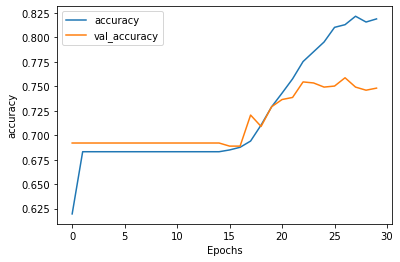

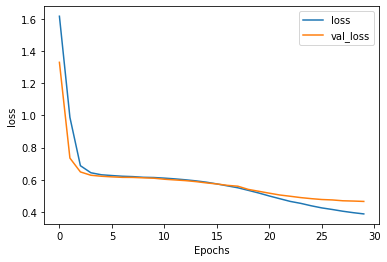

In [138]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [139]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [140]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [141]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

In [162]:
y_pred = model.predict(validation_padded)
#print(validation_padded.shape)
print(validation_label_seq.shape)
print(y_pred.shape)

#print(y_pred)
print(y_pred)
#confusion_matrix = tf.math.confusion_matrix(labels=validation_label_seq, predictions=y_pred)


(945, 1)
(945, 6)
[[1.07917454e-04 1.60630405e-01 8.38887751e-01 1.44340942e-04
  1.40497694e-04 8.90931042e-05]
 [1.23678954e-04 4.44700688e-01 5.54685950e-01 1.78641698e-04
  1.94993016e-04 1.16058502e-04]
 [1.19016200e-04 3.17463189e-01 6.81968093e-01 1.67340768e-04
  1.75441019e-04 1.06870553e-04]
 ...
 [6.10659554e-05 5.19689441e-01 4.79994714e-01 9.25386048e-05
  1.04181359e-04 5.80467422e-05]
 [1.04365958e-04 4.73755300e-01 5.25718749e-01 1.53152199e-04
  1.68942541e-04 9.93718058e-05]
 [1.28975335e-05 9.20308769e-01 7.96094388e-02 2.28352455e-05
  3.10217110e-05 1.48715817e-05]]


### Adding weight to the sexist words using tf-idf 

In [143]:
import re

stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()
  


weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]


print(weighted_words)


['femme', 'fille', 'nana', 'meuf', 'chienne', 'poule', 'garce', 'femelle', 'princesse', 'chose', 'fillette', 'femme objet', 'femme-objet', 'objet', 'ruminante', 'bonne femme', 'potiche', 'biche', 'cocotte', 'journaleuse', 'sex symbol', 'sex symbole', 'daronne', 'diablesse', 'macrelle', 'gonzesse', 'miss', 'femme parfaite', 'dinde', 'feumeu', 'sainte', 'beurette', 'hardeuse', 'dame', 'madame', 'petite dame', 'vraie femme', 'pauvre femme', 'lesbienne ', 'conne', 'connasse', 'cageot', 'casse-bonbon', 'casse-couille', 'casse-couilles', 'chiennasse', 'chienne', 'emmerdeuse', 'folle', 'garage à bite', 'garce', 'gouine', 'gourdasse', 'gourde', 'morue', 'pétasse', 'pouf', 'pouffiasse', 'poufiasse', 'pute', 'salope', 'sorcière', 'traînée', 'vipère', 'bonne', 'petite', 'moche', 'vieille', 'bombe', 'poitrine', 'sein', 'fesses', 'cul', 'grosse', 'vache', 'truie', 'boudin', 'jupe', 'minijupe ', 'mini-jupe', 'robe', 'décolleté', 'cuisses', 'sexy', 'chatte', 'maquillage', 'baleine', 'belle', 'coquett

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

### Naive Bayes classifier

In [145]:
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_0 = []
X_1 = []
for i in range(len(data)):
    if data['class'][i]==0:
        X_0.append(data['tweet'][i])
        
for i in range(len(data)):
    if data['class'][i]==1:
        X_1.append(data['tweet'][i])



vec_0 = CountVectorizer()
X_c0 = vec_0.fit_transform(X_0)
tdm_0 = pd.DataFrame(X_c0.toarray(), columns=vec_0.get_feature_names())


vec_1 = CountVectorizer()
X_c1 = vec_1.fit_transform(X_1)
tdm_1 = pd.DataFrame(X_c1.toarray(), columns=vec_1.get_feature_names())

tdm_1


,02,04,06,10,100,1000,102,12,120,12000,...,yqb,yves,zaimerais,zamzonite,zenash,zeniss,zetais,zlatan,zohrabitan,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_c0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))
freq_0

{'000': 4,
 '10': 7,
 '100': 10,
 '1000': 1,
 '102': 2,
 '10h': 2,
 '10h00': 1,
 '10h30': 1,
 '11': 4,
 '1100': 1,
 '11000': 1,
 '117': 1,
 '12': 8,
 '1200': 1,
 '12000': 1,
 '120battementsparminute': 1,
 '1215': 1,
 '12h': 1,
 '12joursdaction': 1,
 '13': 7,
 '13h50': 1,
 '14': 9,
 '14eme': 1,
 '14h': 1,
 '14h00': 1,
 '14h15': 2,
 '15': 11,
 '157garlamd': 1,
 '15min': 1,
 '15x': 1,
 '16': 4,
 '169': 1,
 '16days': 2,
 '16h': 3,
 '16jours': 3,
 '17': 7,
 '1700': 1,
 '1703': 1,
 '1730': 1,
 '18': 9,
 '180': 1,
 '18006675005': 1,
 '18006686868': 1,
 '1825': 1,
 '18711955': 1,
 '18h': 2,
 '18h00': 1,
 '18h30': 1,
 '18h55': 1,
 '19': 6,
 '1900': 1,
 '1904': 1,
 '1905': 1,
 '1920': 2,
 '1927': 2,
 '1929': 2,
 '195': 2,
 '1954': 1,
 '1962': 1,
 '1965': 1,
 '1970': 1,
 '1979': 1,
 '1986': 1,
 '1987': 1,
 '1992': 1,
 '1999': 1,
 '19e': 1,
 '19h': 1,
 '19h30': 1,
 '19hruthelkrief': 2,
 '1a0maiscpasperdu': 1,
 '1dexmab': 1,
 '1dexmag': 1,
 '1e': 1,
 '1er': 10,
 '1ere': 17,
 '1iran': 1,
 '1les': 1,

In [147]:
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_c1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))
freq_1

{'02': 3,
 '04': 3,
 '06': 1,
 '10': 6,
 '100': 2,
 '1000': 1,
 '102': 1,
 '12': 5,
 '120': 2,
 '12000': 1,
 '12f': 1,
 '13': 4,
 '14': 5,
 '14amp15': 1,
 '14ans': 1,
 '15': 2,
 '150eur': 1,
 '15ans': 1,
 '16': 2,
 '16ans': 1,
 '16days': 2,
 '16jours': 3,
 '17': 1,
 '1964': 1,
 '1990': 1,
 '1992': 2,
 '1997': 2,
 '1998': 1,
 '1999': 1,
 '1cm': 1,
 '1dexmag': 1,
 '1er': 1,
 '1ere': 3,
 '20': 7,
 '2004': 1,
 '2005': 1,
 '2006': 1,
 '2011': 1,
 '20122017': 1,
 '2014': 1,
 '2015': 2,
 '2016': 2,
 '2017': 9,
 '2018': 15,
 '20ans': 1,
 '20hfrance2': 1,
 '20minutes': 2,
 '21': 2,
 '21eme': 2,
 '22': 4,
 '23': 1,
 '24': 1,
 '2499': 1,
 '24hpujadas': 1,
 '25': 2,
 '25janvier': 2,
 '26': 1,
 '26caroll': 1,
 '27': 2,
 '28': 1,
 '2choses': 1,
 '2h': 1,
 '30': 4,
 '31': 1,
 '32': 1,
 '36': 1,
 '3600x': 1,
 '364': 1,
 '3784e': 1,
 '38': 2,
 '3eme': 1,
 '3min': 1,
 '40': 1,
 '40t': 1,
 '44': 1,
 '44t': 1,
 '4h': 1,
 '4meur': 1,
 '50': 5,
 '500': 1,
 '5000': 1,
 '50100500': 1,
 '50euros': 1,
 '50nuanc

In [148]:
prob_0 = []
for word,count in zip(word_list_0,count_list_0):
    prob_0.append(count/len(word_list_0))
dict(zip(word_list_0,prob_0))


{'000': 0.00043677658877484165,
 '10': 0.0007643590303559729,
 '100': 0.0010919414719371041,
 '1000': 0.00010919414719371041,
 '102': 0.00021838829438742082,
 '10h': 0.00021838829438742082,
 '10h00': 0.00010919414719371041,
 '10h30': 0.00010919414719371041,
 '11': 0.00043677658877484165,
 '1100': 0.00010919414719371041,
 '11000': 0.00010919414719371041,
 '117': 0.00010919414719371041,
 '12': 0.0008735531775496833,
 '1200': 0.00010919414719371041,
 '12000': 0.00010919414719371041,
 '120battementsparminute': 0.00010919414719371041,
 '1215': 0.00010919414719371041,
 '12h': 0.00010919414719371041,
 '12joursdaction': 0.00010919414719371041,
 '13': 0.0007643590303559729,
 '13h50': 0.00010919414719371041,
 '14': 0.0009827473247433938,
 '14eme': 0.00010919414719371041,
 '14h': 0.00010919414719371041,
 '14h00': 0.00010919414719371041,
 '14h15': 0.00021838829438742082,
 '15': 0.0012011356191308146,
 '157garlamd': 0.00010919414719371041,
 '15min': 0.00010919414719371041,
 '15x': 0.000109194147193

In [149]:
prob_1 = []
for word,count in zip(word_list_1,count_list_1):
    prob_1.append(count/len(word_list_1))
dict(zip(word_list_1,prob_1))


{'02': 0.0005337128624799857,
 '04': 0.0005337128624799857,
 '06': 0.0001779042874933286,
 '10': 0.0010674257249599715,
 '100': 0.0003558085749866572,
 '1000': 0.0001779042874933286,
 '102': 0.0001779042874933286,
 '12': 0.000889521437466643,
 '120': 0.0003558085749866572,
 '12000': 0.0001779042874933286,
 '12f': 0.0001779042874933286,
 '13': 0.0007116171499733144,
 '14': 0.000889521437466643,
 '14amp15': 0.0001779042874933286,
 '14ans': 0.0001779042874933286,
 '15': 0.0003558085749866572,
 '150eur': 0.0001779042874933286,
 '15ans': 0.0001779042874933286,
 '16': 0.0003558085749866572,
 '16ans': 0.0001779042874933286,
 '16days': 0.0003558085749866572,
 '16jours': 0.0005337128624799857,
 '17': 0.0001779042874933286,
 '1964': 0.0001779042874933286,
 '1990': 0.0001779042874933286,
 '1992': 0.0003558085749866572,
 '1997': 0.0003558085749866572,
 '1998': 0.0001779042874933286,
 '1999': 0.0001779042874933286,
 '1cm': 0.0001779042874933286,
 '1dexmag': 0.0001779042874933286,
 '1er': 0.00017790

In [150]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)
X_train_0 = []
X_train_1 = []
print(X_train)
print(X_train.index)

index =  X_train.index
for i in index:
    if (y_train[i]==0):
        X_train_0.append(X_train[i])
    else:
        X_train_1.append(X_train[i])       

1609    dans armeedelair  pas inegalites de salaires e...
503              meilleure  aime plus tout balancetonporc
2295    nappellerai pas ca journaliste est tellement s...
783     etmaintenant joignezvous mouvement signez amp ...
1435    fille adoptive de woodyallen detaille agressio...
                              ...                        
732     solidaritefemme membre du collectif ensembleco...
527     angela merkel vient de feliciter hongrois vikt...
777     + affligeant dans laveritesurlesfilles est c c...
2421    campagne plus ridicule du mondeest vrai stress...
79      marianorajoy tweete espagnol theresamay tweete...
Name: tweet, Length: 2203, dtype: object
Int64Index([1609,  503, 2295,  783, 1435, 1466, 1958,  271, 1704, 1950,
            ...
            2848, 1734, 1954,  393, 1243,  732,  527,  777, 2421,   79],
           dtype='int64', length=2203)


In [151]:
vec_0 = CountVectorizer()
X_vec_0 = vec_0.fit_transform(X_train_0)

total_features0 = len(vec_0.get_feature_names())
total_features0


7266

In [152]:
vec_1 = CountVectorizer()
X_vec_1 = vec_1.fit_transform(X_train_1)

total_features1 = len(vec_1.get_feature_names())
total_features1

proba0 = total_features0 / (total_features0+total_features1)
proba1 = total_features1 / (total_features0+total_features1)

print(proba0)
print(proba1)

0.6232095376962004
0.37679046230379964


In [153]:
total_cnts_features_0 = count_list_0.sum(axis=0)
total_cnts_features_1 = count_list_1.sum(axis=0)

In [154]:
from nltk.tokenize import word_tokenize
new_sentence = 'what is the price of the book'
new_word_list = word_tokenize(new_sentence)

In [155]:
def proba_sentence_class0(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_0.keys():
            count = freq_0[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_0 + total_features0))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba0
    return res


In [156]:
def proba_sentence_class1(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_1.keys():
            count = freq_1[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_1 + total_features1))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba1
    return res

print(proba_sentence_class1("what is the price of the book"))

2.075591881789903e-31


In [157]:
predictions = []
for i in X_test:
    print(i)
    proba_class0 = proba_sentence_class0(i)
    proba_class1 = proba_sentence_class1(i)
    if proba_class0 > proba_class1:
        predictions.append(0)
    else:
        predictions.append(1)
        
print(predictions)

balancetonporc  responsabilite collective  by sophiebarel
hallucinantcatherine deneuve signataires mais pour certains est tribune de catherine deneuvemalhonnetete ou paresse intellectuelle  fatigue
article  mansplaining  de wikipediafr ete cree mars 2013 avant equivalent anglais sexisme
voir sur couverture de magazines pseudo plaidoyer pour quon donne enfin  parole aux hommes  pauvres femmes sont si mechantes  wtf consternant heureusement lire intervention de robert redford qui vous rasserene  metoo balancetonporc
bref sexisme est vraiment cool
 joxe il capable du meilleur comme du pire mais est dans pire quil meilleur  metoo balancetonporc
miss france est pas balancetonporc est balance cv  jade feret
 appel de 1 000 jeunes filles  contre 100 merci pour cette tribune feministe  metoo
laprovence justice passe sans sexisme djihad warcrime amp crime contre humanity oumanite apartheid de humanite ps  partie pour rejoindre neant dont elle naurait jamais du sortir causeur tvlofficiel libe
su

rt orsys pourquoi jecrirai lettre chaque propos sexiste entendu dans cadre de travail  sexisme parite feminisme entreprise carriere o
balancetonporc frero passe me voir voisin interpelle lui disant retourne chez toi arabe entre autre frero voulu lui expliqe vi sodomisant il e parti courant bh dormire moin con sachant q 1 elevage de porc cote dchez moi
maintenant est femme  bigre  ===gt gerald darmanin revele avoir ete accuse de viol par homme via valeurs
acimed revient sur traitement mediatique de balancetonporc premier article sur biais un certain nombre de medias commentateurs
quand fais de merde ne vais pas applaudir exemple meilleure amie de 20 ans enceinte ayant ni travail ni projets suis incapable applaudir ou etre heureux face ca
16jours fait environ 120 millions de femmes agees de moins de 20 ans ont deja ete victimes un viol ou actes sexuels forces source unicef moiaussi unicefsa unfpasa unwomenafrica unsouthafrica ilesttemps orangerlemonde
aujourhui berlin emmanuelmacron ange

prefet72 marleneschiappa jcboulard lemenerdom cmorancais damienpichereau fpersonne slefoll karamanli72 nadinegrelet ljncg72 comment parler egalite entre homme femme lorsque femme base de propres ideesfortune quelle ne beneficie de strictement rien
cet article du monde diplomatique sur sexisme tres convainquant promis jour ce journal autorisera meme femmes ecrire pour lui
jsavais pas ct possible etre connasse ce point mais meufs nont pas de limite
brutofficiel mais bien sur  egalite salariale femmehomme dans code du travail vigueur depuis de nombreuses annees france google ami monsieur journaliste
le recours aux ordonnances pour reforme du code du travail na pas empeche debat il me parait legitime gouvernement saisisse un sujet tel reforme de sncf debat aura bien lieu parlement spinetta franceinfo lesinformes
justice va devoir pencher sur raisons qui ont conduit renvoi du proces de tron balancetonporc prend pas sur droit 
grandparisexpress deputes lareman groupemodem recus 8h ce matin p

In [158]:
total_labels = len(y_test)
acc = 0
for i in range(len(y_test)):
    if(y_test[y_test.index[i]]==predictions[i]):
        acc = acc + 1
        
acc = acc / total_labels
print("Accuracy :" , acc)
        
metrics.confusion_matrix(y_test, predictions)

Accuracy : 0.8465608465608465


array([[512, 141],
       [  4, 288]])

### NNL + Oversampling

In [196]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros_train, y_ros_train = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_ros_train = X_ros_train.tolist()
X_ros_test = X_ros_test.tolist()


In [197]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_ros_train)

In [198]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

2152
{'<OOV>': 1, 'millions de femmes ont libere leur parole durant mouvement moiaussi aujourhui nous voulons souligner leur courage reiterer notre solidarite etmaintenant envisageons avenir joignez mouvement endossez declaration': 2, 'stereotypes font vie dure  pour pres de 9 personnes sur 10 ce qui differencie tout premier lieu homme une femme est facon exprimer sentiments help sexisme': 3, 'on ne peut plus rire sans etre accuse antisemitisme de sexisme homophobie de racisme de discrimination etc on ne peut plus rire de tout avec personne france devenu pays de victimes amp de pleureuses est affligeant riez peu putain': 4, 'sexisme nest pas quaffaire de stereotypes inconscients est aussi morale de difference sexes organisant certain ordre social': 5, 'reve de vivre dans ville ou porter talons hauts jupe nest ni acte une femme soumise ni celui une salope': 6, 'sexisme dans etudes medicales  pres de 9 internes sur 10 ont ete temoins de sexisme quotidien via isnitwit': 7, 'relancer viols

In [199]:
train_sequences = tokenizer.texts_to_sequences(X_ros_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_ros_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [200]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_test))



In [201]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 24)                408       
                                                                 
 dense_11 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [202]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
95/95 - 1s - loss: 1.4922 - accuracy: 0.4865 - val_loss: 1.0553 - val_accuracy: 0.5000 - 581ms/epoch - 6ms/step
Epoch 2/30
95/95 - 0s - loss: 0.8213 - accuracy: 0.5007 - val_loss: 0.7250 - val_accuracy: 0.5000 - 147ms/epoch - 2ms/step
Epoch 3/30
95/95 - 0s - loss: 0.7119 - accuracy: 0.4921 - val_loss: 0.7033 - val_accuracy: 0.5000 - 157ms/epoch - 2ms/step
Epoch 4/30
95/95 - 0s - loss: 0.7006 - accuracy: 0.4967 - val_loss: 0.6983 - val_accuracy: 0.5000 - 157ms/epoch - 2ms/step
Epoch 5/30
95/95 - 0s - loss: 0.6977 - accuracy: 0.5168 - val_loss: 0.6963 - val_accuracy: 0.4899 - 171ms/epoch - 2ms/step
Epoch 6/30
95/95 - 0s - loss: 0.6967 - accuracy: 0.5083 - val_loss: 0.6954 - val_accuracy: 0.5000 - 166ms/epoch - 2ms/step
Epoch 7/30
95/95 - 0s - loss: 0.6960 - accuracy: 0.4970 - val_loss: 0.6955 - val_accuracy: 0.5000 - 160ms/epoch - 2ms/step
Epoch 8/30
95/95 - 0s - loss: 0.6950 - accuracy: 0.4884 - val_loss: 0.6945 - val_accuracy: 0.5000 - 157ms/epoch - 2ms/step
Epoch 9/30
95/95

### NNL + Undersampling

In [206]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

# instantiating the random over sampler 
rus = RandomUnderSampler()
# resampling X, y
X_rus_train, y_rus_train = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_rus_test, y_rus_test = rus.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_rus_train = X_rus_train.tolist()
X_rus_test = X_rus_test.tolist()


In [213]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_rus_train)

In [214]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

1316
{'<OOV>': 1, 'millions de femmes ont libere leur parole durant mouvement moiaussi aujourhui nous voulons souligner leur courage reiterer notre solidarite etmaintenant envisageons avenir joignez mouvement endossez declaration': 2, 'sexisme nest pas quaffaire de stereotypes inconscients est aussi morale de difference sexes organisant certain ordre social': 3, 'balancetonporc  liberation de parole sous caution mediatique': 4, 'quand balancetonporc fait derailler proces tron via lefigaro': 5, 'generation windrush  qui sont ces citoyens anglais origine antillaise dans viseur de theresa may ': 6, 'pour lutter contre sexisme cette celebre actrice va arreter de tourner  video': 7, 'campagne moiaussi divise femmes france': 8, 'moira sauvage excisionparlons une pensee pour toutes filles excisees dans monde 1 toutes 6 minutes forme plus terrible du sexisme qui choisit avance destin femmes ensemblecontrelesexisme 25janvier': 9, 'moiaussi dis  etmaintenant  via lplapresse': 10, 'stereotypes fo

In [215]:
train_sequences = tokenizer.texts_to_sequences(X_rus_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_rus_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [216]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_test))



In [217]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dense_15 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [218]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
42/42 - 0s - loss: 1.6543 - accuracy: 0.5000 - val_loss: 1.5064 - val_accuracy: 0.5000 - 484ms/epoch - 12ms/step
Epoch 2/30
42/42 - 0s - loss: 1.3259 - accuracy: 0.5000 - val_loss: 1.1465 - val_accuracy: 0.5000 - 76ms/epoch - 2ms/step
Epoch 3/30
42/42 - 0s - loss: 1.0288 - accuracy: 0.5000 - val_loss: 0.9120 - val_accuracy: 0.5000 - 74ms/epoch - 2ms/step
Epoch 4/30
42/42 - 0s - loss: 0.8353 - accuracy: 0.5000 - val_loss: 0.7718 - val_accuracy: 0.5000 - 82ms/epoch - 2ms/step
Epoch 5/30
42/42 - 0s - loss: 0.7442 - accuracy: 0.5000 - val_loss: 0.7229 - val_accuracy: 0.5000 - 86ms/epoch - 2ms/step
Epoch 6/30
42/42 - 0s - loss: 0.7147 - accuracy: 0.5000 - val_loss: 0.7082 - val_accuracy: 0.5000 - 87ms/epoch - 2ms/step
Epoch 7/30
42/42 - 0s - loss: 0.7053 - accuracy: 0.4970 - val_loss: 0.7025 - val_accuracy: 0.5000 - 91ms/epoch - 2ms/step
Epoch 8/30
42/42 - 0s - loss: 0.7010 - accuracy: 0.5068 - val_loss: 0.6996 - val_accuracy: 0.5000 - 83ms/epoch - 2ms/step
Epoch 9/30
42/42 - 0s 

### NAIVES BAYES + OVERSAMPLING

In [219]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_0 = []
X_1 = []
for i in range(len(data)):
    if data['class'][i]==0:
        X_0.append(data['tweet'][i])
        
for i in range(len(data)):
    if data['class'][i]==1:
        X_1.append(data['tweet'][i])

vec_0 = CountVectorizer()
X_c0 = vec_0.fit_transform(X_0)
tdm_0 = pd.DataFrame(X_c0.toarray(), columns=vec_0.get_feature_names())


vec_1 = CountVectorizer()
X_c1 = vec_1.fit_transform(X_1)
tdm_1 = pd.DataFrame(X_c1.toarray(), columns=vec_1.get_feature_names())

tdm_1

,02,04,06,10,100,1000,102,12,120,12000,...,yqb,yves,zaimerais,zamzonite,zenash,zeniss,zetais,zlatan,zohrabitan,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_c0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))
freq_0

{'000': 4,
 '10': 7,
 '100': 10,
 '1000': 1,
 '102': 2,
 '10h': 2,
 '10h00': 1,
 '10h30': 1,
 '11': 4,
 '1100': 1,
 '11000': 1,
 '117': 1,
 '12': 8,
 '1200': 1,
 '12000': 1,
 '120battementsparminute': 1,
 '1215': 1,
 '12h': 1,
 '12joursdaction': 1,
 '13': 7,
 '13h50': 1,
 '14': 9,
 '14eme': 1,
 '14h': 1,
 '14h00': 1,
 '14h15': 2,
 '15': 11,
 '157garlamd': 1,
 '15min': 1,
 '15x': 1,
 '16': 4,
 '169': 1,
 '16days': 2,
 '16h': 3,
 '16jours': 3,
 '17': 7,
 '1700': 1,
 '1703': 1,
 '1730': 1,
 '18': 9,
 '180': 1,
 '18006675005': 1,
 '18006686868': 1,
 '1825': 1,
 '18711955': 1,
 '18h': 2,
 '18h00': 1,
 '18h30': 1,
 '18h55': 1,
 '19': 6,
 '1900': 1,
 '1904': 1,
 '1905': 1,
 '1920': 2,
 '1927': 2,
 '1929': 2,
 '195': 2,
 '1954': 1,
 '1962': 1,
 '1965': 1,
 '1970': 1,
 '1979': 1,
 '1986': 1,
 '1987': 1,
 '1992': 1,
 '1999': 1,
 '19e': 1,
 '19h': 1,
 '19h30': 1,
 '19hruthelkrief': 2,
 '1a0maiscpasperdu': 1,
 '1dexmab': 1,
 '1dexmag': 1,
 '1e': 1,
 '1er': 10,
 '1ere': 17,
 '1iran': 1,
 '1les': 1,

In [221]:
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_c1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))
freq_1

{'02': 3,
 '04': 3,
 '06': 1,
 '10': 6,
 '100': 2,
 '1000': 1,
 '102': 1,
 '12': 5,
 '120': 2,
 '12000': 1,
 '12f': 1,
 '13': 4,
 '14': 5,
 '14amp15': 1,
 '14ans': 1,
 '15': 2,
 '150eur': 1,
 '15ans': 1,
 '16': 2,
 '16ans': 1,
 '16days': 2,
 '16jours': 3,
 '17': 1,
 '1964': 1,
 '1990': 1,
 '1992': 2,
 '1997': 2,
 '1998': 1,
 '1999': 1,
 '1cm': 1,
 '1dexmag': 1,
 '1er': 1,
 '1ere': 3,
 '20': 7,
 '2004': 1,
 '2005': 1,
 '2006': 1,
 '2011': 1,
 '20122017': 1,
 '2014': 1,
 '2015': 2,
 '2016': 2,
 '2017': 9,
 '2018': 15,
 '20ans': 1,
 '20hfrance2': 1,
 '20minutes': 2,
 '21': 2,
 '21eme': 2,
 '22': 4,
 '23': 1,
 '24': 1,
 '2499': 1,
 '24hpujadas': 1,
 '25': 2,
 '25janvier': 2,
 '26': 1,
 '26caroll': 1,
 '27': 2,
 '28': 1,
 '2choses': 1,
 '2h': 1,
 '30': 4,
 '31': 1,
 '32': 1,
 '36': 1,
 '3600x': 1,
 '364': 1,
 '3784e': 1,
 '38': 2,
 '3eme': 1,
 '3min': 1,
 '40': 1,
 '40t': 1,
 '44': 1,
 '44t': 1,
 '4h': 1,
 '4meur': 1,
 '50': 5,
 '500': 1,
 '5000': 1,
 '50100500': 1,
 '50euros': 1,
 '50nuanc

In [222]:
prob_0 = []
for word,count in zip(word_list_0,count_list_0):
    prob_0.append(count/len(word_list_0))
dict(zip(word_list_0,prob_0))


{'000': 0.00043677658877484165,
 '10': 0.0007643590303559729,
 '100': 0.0010919414719371041,
 '1000': 0.00010919414719371041,
 '102': 0.00021838829438742082,
 '10h': 0.00021838829438742082,
 '10h00': 0.00010919414719371041,
 '10h30': 0.00010919414719371041,
 '11': 0.00043677658877484165,
 '1100': 0.00010919414719371041,
 '11000': 0.00010919414719371041,
 '117': 0.00010919414719371041,
 '12': 0.0008735531775496833,
 '1200': 0.00010919414719371041,
 '12000': 0.00010919414719371041,
 '120battementsparminute': 0.00010919414719371041,
 '1215': 0.00010919414719371041,
 '12h': 0.00010919414719371041,
 '12joursdaction': 0.00010919414719371041,
 '13': 0.0007643590303559729,
 '13h50': 0.00010919414719371041,
 '14': 0.0009827473247433938,
 '14eme': 0.00010919414719371041,
 '14h': 0.00010919414719371041,
 '14h00': 0.00010919414719371041,
 '14h15': 0.00021838829438742082,
 '15': 0.0012011356191308146,
 '157garlamd': 0.00010919414719371041,
 '15min': 0.00010919414719371041,
 '15x': 0.000109194147193

In [223]:
prob_1 = []
for word,count in zip(word_list_1,count_list_1):
    prob_1.append(count/len(word_list_1))
dict(zip(word_list_1,prob_1))


{'02': 0.0005337128624799857,
 '04': 0.0005337128624799857,
 '06': 0.0001779042874933286,
 '10': 0.0010674257249599715,
 '100': 0.0003558085749866572,
 '1000': 0.0001779042874933286,
 '102': 0.0001779042874933286,
 '12': 0.000889521437466643,
 '120': 0.0003558085749866572,
 '12000': 0.0001779042874933286,
 '12f': 0.0001779042874933286,
 '13': 0.0007116171499733144,
 '14': 0.000889521437466643,
 '14amp15': 0.0001779042874933286,
 '14ans': 0.0001779042874933286,
 '15': 0.0003558085749866572,
 '150eur': 0.0001779042874933286,
 '15ans': 0.0001779042874933286,
 '16': 0.0003558085749866572,
 '16ans': 0.0001779042874933286,
 '16days': 0.0003558085749866572,
 '16jours': 0.0005337128624799857,
 '17': 0.0001779042874933286,
 '1964': 0.0001779042874933286,
 '1990': 0.0001779042874933286,
 '1992': 0.0003558085749866572,
 '1997': 0.0003558085749866572,
 '1998': 0.0001779042874933286,
 '1999': 0.0001779042874933286,
 '1cm': 0.0001779042874933286,
 '1dexmag': 0.0001779042874933286,
 '1er': 0.00017790

In [250]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros_train, y_ros_train = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 

X_train_0 = []
X_train_1 = []

for i in range(len(X_ros_train)):
    if (y_ros_train[i]==0):
        X_train_0.append(X_ros_train[i].tolist()[0])
    else:
        X_train_1.append(X_ros_train[i].tolist()[0])

In [252]:
vec_0 = CountVectorizer()
X_vec_0 = vec_0.fit_transform(X_train_0)

total_features0 = len(vec_0.get_feature_names())
total_features0


7175

In [253]:
vec_1 = CountVectorizer()
X_vec_1 = vec_1.fit_transform(X_train_1)

total_features1 = len(vec_1.get_feature_names())
total_features1

proba0 = total_features0 / (total_features0+total_features1)
proba1 = total_features1 / (total_features0+total_features1)

print(proba0)
print(proba1)

0.6156156156156156
0.3843843843843844


In [254]:
total_cnts_features_0 = count_list_0.sum(axis=0)
total_cnts_features_1 = count_list_1.sum(axis=0)

In [255]:
from nltk.tokenize import word_tokenize
new_sentence = 'what is the price of the book'
new_word_list = word_tokenize(new_sentence)

In [256]:
def proba_sentence_class0(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_0.keys():
            count = freq_0[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_0 + total_features0))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba0
    return res


In [257]:
def proba_sentence_class1(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_1.keys():
            count = freq_1[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_1 + total_features1))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba1
    return res

print(proba_sentence_class1("what is the price of the book"))

2.0626937950927426e-31


In [282]:
predictions = []
for i in X_ros_test:
    print(i)
    proba_class0 = proba_sentence_class0(i[0])
    proba_class1 = proba_sentence_class1(i[0])
    if proba_class0 > proba_class1:
        predictions.append(0)
    else:
        predictions.append(1)
        
print(predictions)

['balancetonporc  sandra muller attaquee diffamation']
['apres avoir parler violences faites aux femmes tf1 toute logique zoom sur fesses miss est juste incroyable  balancetonporc missfrance2018']
['balancetonporc  responsabilite collective  by sophiebarel']
['mehdi ils ont truc plus cm']
['bonne premiere mitemps deuxiemes on na domine beau match amelmajri7 bouhaddisarah els9france wrenard aller bleues']
['lisez notre texte  etmaintenant  solidaires derriere moiaussi tlmep']
['cedricrs francoisfillon fillon est tue tout seulcostumesemployer femme enfantcheque du senatest argent qui a tue']
['carla mais carla putin mais quest ce quelle conne cette pauvre fille perdu de societe  lma lmea w9']
['vp2 | apres metoo balancetonporc ou eston  gtegalitefh journeedesdroitsdesfemmes 8mars lt3']
['waterpolo len europa cup oosterhout j1 bleues inclinent 195 face aux paysbas rdv demain face espagne allezlesbleues']
['annedesevrant loreal lorealparisfr toujours probleme qd shampoo lance ds bain de po

['cc paulineboyer33 personnalite de annee et autres annees aussi balancetonporc']
['fin d39une semaine eprouvante durant laquelle segolene royal demontre capacite de depassement de courage de femme d39etat wow']
['ocombey photosdeheyce peu importe situation mais eglise devoir de preparer jeunes soeurs par billets veuves homme peut aider femme mais mariage pour femmes matures pretes cuisine particulier domaine femmes']
['jeanmichel apathie considere robe aurore berge non adaptee parole politique il convient donc desormais de faire distinction entre ce qui bien a gauche ce qui nest pas bien a droite bienvenue dans monde merveilleux neoprogressistes ']
['pere il a dit aujourhui truc 3600x lui fais oui papa sais merci il me chuchote dans oreille  va te faire foutre grosse connasse  eh mercee papa']
['leasalame  christiane taubira vous sentezvous visee quand emmanuel macron parle de lien abime avec eglise  chtaubira ']
['enceinte sur marche du travail   est handicap notoire   bienvenue 2018

In [283]:
total_labels = len(y_ros_test)
acc = 0
for i in range(len(y_ros_test)):
    if(y_ros_test[i]==predictions[i]):
        acc = acc + 1
        
acc = acc / total_labels
print("Accuracy :" , acc)
        
metrics.confusion_matrix(y_ros_test, predictions)

Accuracy : 0.8823529411764706


array([[512, 151],
       [  5, 658]])

### NAIVES BAYES + UNDERSAMPLING

In [261]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_0 = []
X_1 = []
for i in range(len(data)):
    if data['class'][i]==0:
        X_0.append(data['tweet'][i])
        
for i in range(len(data)):
    if data['class'][i]==1:
        X_1.append(data['tweet'][i])

vec_0 = CountVectorizer()
X_c0 = vec_0.fit_transform(X_0)
tdm_0 = pd.DataFrame(X_c0.toarray(), columns=vec_0.get_feature_names())


vec_1 = CountVectorizer()
X_c1 = vec_1.fit_transform(X_1)
tdm_1 = pd.DataFrame(X_c1.toarray(), columns=vec_1.get_feature_names())

tdm_1

,02,04,06,10,100,1000,102,12,120,12000,...,yqb,yves,zaimerais,zamzonite,zenash,zeniss,zetais,zlatan,zohrabitan,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_c0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))
freq_0

{'000': 4,
 '10': 7,
 '100': 10,
 '1000': 1,
 '102': 2,
 '10h': 2,
 '10h00': 1,
 '10h30': 1,
 '11': 4,
 '1100': 1,
 '11000': 1,
 '117': 1,
 '12': 8,
 '1200': 1,
 '12000': 1,
 '120battementsparminute': 1,
 '1215': 1,
 '12h': 1,
 '12joursdaction': 1,
 '13': 7,
 '13h50': 1,
 '14': 9,
 '14eme': 1,
 '14h': 1,
 '14h00': 1,
 '14h15': 2,
 '15': 11,
 '157garlamd': 1,
 '15min': 1,
 '15x': 1,
 '16': 4,
 '169': 1,
 '16days': 2,
 '16h': 3,
 '16jours': 3,
 '17': 7,
 '1700': 1,
 '1703': 1,
 '1730': 1,
 '18': 9,
 '180': 1,
 '18006675005': 1,
 '18006686868': 1,
 '1825': 1,
 '18711955': 1,
 '18h': 2,
 '18h00': 1,
 '18h30': 1,
 '18h55': 1,
 '19': 6,
 '1900': 1,
 '1904': 1,
 '1905': 1,
 '1920': 2,
 '1927': 2,
 '1929': 2,
 '195': 2,
 '1954': 1,
 '1962': 1,
 '1965': 1,
 '1970': 1,
 '1979': 1,
 '1986': 1,
 '1987': 1,
 '1992': 1,
 '1999': 1,
 '19e': 1,
 '19h': 1,
 '19h30': 1,
 '19hruthelkrief': 2,
 '1a0maiscpasperdu': 1,
 '1dexmab': 1,
 '1dexmag': 1,
 '1e': 1,
 '1er': 10,
 '1ere': 17,
 '1iran': 1,
 '1les': 1,

In [263]:
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_c1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))
freq_1

{'02': 3,
 '04': 3,
 '06': 1,
 '10': 6,
 '100': 2,
 '1000': 1,
 '102': 1,
 '12': 5,
 '120': 2,
 '12000': 1,
 '12f': 1,
 '13': 4,
 '14': 5,
 '14amp15': 1,
 '14ans': 1,
 '15': 2,
 '150eur': 1,
 '15ans': 1,
 '16': 2,
 '16ans': 1,
 '16days': 2,
 '16jours': 3,
 '17': 1,
 '1964': 1,
 '1990': 1,
 '1992': 2,
 '1997': 2,
 '1998': 1,
 '1999': 1,
 '1cm': 1,
 '1dexmag': 1,
 '1er': 1,
 '1ere': 3,
 '20': 7,
 '2004': 1,
 '2005': 1,
 '2006': 1,
 '2011': 1,
 '20122017': 1,
 '2014': 1,
 '2015': 2,
 '2016': 2,
 '2017': 9,
 '2018': 15,
 '20ans': 1,
 '20hfrance2': 1,
 '20minutes': 2,
 '21': 2,
 '21eme': 2,
 '22': 4,
 '23': 1,
 '24': 1,
 '2499': 1,
 '24hpujadas': 1,
 '25': 2,
 '25janvier': 2,
 '26': 1,
 '26caroll': 1,
 '27': 2,
 '28': 1,
 '2choses': 1,
 '2h': 1,
 '30': 4,
 '31': 1,
 '32': 1,
 '36': 1,
 '3600x': 1,
 '364': 1,
 '3784e': 1,
 '38': 2,
 '3eme': 1,
 '3min': 1,
 '40': 1,
 '40t': 1,
 '44': 1,
 '44t': 1,
 '4h': 1,
 '4meur': 1,
 '50': 5,
 '500': 1,
 '5000': 1,
 '50100500': 1,
 '50euros': 1,
 '50nuanc

In [264]:
prob_0 = []
for word,count in zip(word_list_0,count_list_0):
    prob_0.append(count/len(word_list_0))
dict(zip(word_list_0,prob_0))


{'000': 0.00043677658877484165,
 '10': 0.0007643590303559729,
 '100': 0.0010919414719371041,
 '1000': 0.00010919414719371041,
 '102': 0.00021838829438742082,
 '10h': 0.00021838829438742082,
 '10h00': 0.00010919414719371041,
 '10h30': 0.00010919414719371041,
 '11': 0.00043677658877484165,
 '1100': 0.00010919414719371041,
 '11000': 0.00010919414719371041,
 '117': 0.00010919414719371041,
 '12': 0.0008735531775496833,
 '1200': 0.00010919414719371041,
 '12000': 0.00010919414719371041,
 '120battementsparminute': 0.00010919414719371041,
 '1215': 0.00010919414719371041,
 '12h': 0.00010919414719371041,
 '12joursdaction': 0.00010919414719371041,
 '13': 0.0007643590303559729,
 '13h50': 0.00010919414719371041,
 '14': 0.0009827473247433938,
 '14eme': 0.00010919414719371041,
 '14h': 0.00010919414719371041,
 '14h00': 0.00010919414719371041,
 '14h15': 0.00021838829438742082,
 '15': 0.0012011356191308146,
 '157garlamd': 0.00010919414719371041,
 '15min': 0.00010919414719371041,
 '15x': 0.000109194147193

In [265]:
prob_1 = []
for word,count in zip(word_list_1,count_list_1):
    prob_1.append(count/len(word_list_1))
dict(zip(word_list_1,prob_1))


{'02': 0.0005337128624799857,
 '04': 0.0005337128624799857,
 '06': 0.0001779042874933286,
 '10': 0.0010674257249599715,
 '100': 0.0003558085749866572,
 '1000': 0.0001779042874933286,
 '102': 0.0001779042874933286,
 '12': 0.000889521437466643,
 '120': 0.0003558085749866572,
 '12000': 0.0001779042874933286,
 '12f': 0.0001779042874933286,
 '13': 0.0007116171499733144,
 '14': 0.000889521437466643,
 '14amp15': 0.0001779042874933286,
 '14ans': 0.0001779042874933286,
 '15': 0.0003558085749866572,
 '150eur': 0.0001779042874933286,
 '15ans': 0.0001779042874933286,
 '16': 0.0003558085749866572,
 '16ans': 0.0001779042874933286,
 '16days': 0.0003558085749866572,
 '16jours': 0.0005337128624799857,
 '17': 0.0001779042874933286,
 '1964': 0.0001779042874933286,
 '1990': 0.0001779042874933286,
 '1992': 0.0003558085749866572,
 '1997': 0.0003558085749866572,
 '1998': 0.0001779042874933286,
 '1999': 0.0001779042874933286,
 '1cm': 0.0001779042874933286,
 '1dexmag': 0.0001779042874933286,
 '1er': 0.00017790

In [278]:
X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

# instantiating the random over sampler 
rus = RandomUnderSampler()
# resampling X, y
X_rus_train, y_rus_train = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_rus_test, y_rus_test = rus.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 

X_train_0 = []
X_train_1 = []

for i in range(len(X_rus_train)):
    if (y_ros_train[i]==0):
        X_train_0.append(X_rus_train[i].tolist()[0])
    else:
        X_train_1.append(X_rus_train[i].tolist()[0])

In [268]:
vec_0 = CountVectorizer()
X_vec_0 = vec_0.fit_transform(X_train_0)

total_features0 = len(vec_0.get_feature_names())
total_features0


5518

In [269]:
vec_1 = CountVectorizer()
X_vec_1 = vec_1.fit_transform(X_train_1)

total_features1 = len(vec_1.get_feature_names())
total_features1

proba0 = total_features0 / (total_features0+total_features1)
proba1 = total_features1 / (total_features0+total_features1)

print(proba0)
print(proba1)

0.6384357283350689
0.36156427166493116


In [270]:
total_cnts_features_0 = count_list_0.sum(axis=0)
total_cnts_features_1 = count_list_1.sum(axis=0)

In [271]:
new_sentence = 'what is the price of the book'
new_word_list = word_tokenize(new_sentence)

In [280]:
predictions = []
for i in X_rus_test:
    print(i)
    proba_class0 = proba_sentence_class0(i[0])
    proba_class1 = proba_sentence_class1(i[0])
    if proba_class0 > proba_class1:
        predictions.append(0)
    else:
        predictions.append(1)
        
print(predictions)

['comment ca sur insta y gens qui postent par theme mode photos bleues samedi prochain pis apres est rose']
['sexisme ordinaire harcelement comment parler  on donne rendezvous jeudi 1er fevrier de 9h 10h30 pour conference theatralisee animee par unroleajouer equilibreseu pour vous inscrire ']
['angela merkel bientot paris pour parler europe | scoopit']
['tw agression sexuelle le fait nous avions epoque 14 15 ans mais apparemment ca ne a pas derange plus ca balancetonporc metoo']
['jaime video youtube  taharrush gamea  ou viol autorise adresse']
['seule realisatrice apres guerre jacqueline audry donna films tonalite feministe ils sont decouvrir sur cine+ classic ']
['mise jour concernant scandale windrush  gouvernement soutien theresa may apres demission amber rudd ministre de interieur il faut dire may facheuse posture  cet  environnement hostile  est elle qui a cree']
['montreal quotidien sorti de presse tlmep moiaussi']
['de gauche droite  angela merkel chanceliere allemande jena has

In [281]:
total_labels = len(y_rus_test)
acc = 0
for i in range(len(y_rus_test)):
    if(y_rus_test[i]==predictions[i]):
        acc = acc + 1
        
acc = acc / total_labels
print("Accuracy :" , acc)
        
metrics.confusion_matrix(y_rus_test, predictions)

Accuracy : 0.8956228956228957


array([[237,  60],
       [  2, 295]])

In [194]:
# ==> ajouter les poids
# ==> matrice de confusion
# ==> meler plusieurs methodes
# ==> tester avec des paramètres différents 
# ==> faire un joli fichier